## Notebook purpose

The aim of that research is finding the way of estimating assets covariation<br>
The question of estimating the covariance matrix arises for the following reason:<br>
sometimes we need to now covariance between assets for efficient portfolio rebalancing or other goals,<br>
but some covariance coefficients can be distorted if the length of data sample (N) is comparable to the number of assets (T).<br>

Why? Because covariance matrix has about 0.5 * (N-1) * N params (where N is the number of assets). <br>
If the N/T ratio is near to 1 or even 0.01, we will use number of the observations comparable to the number of params that we estimate.<br>
That can lead to inadequate results. And in that step we need use some methods for matrix covariance matrix shrinkage.<br>

Shrinkage is a synonym to the compression. We make the biggest covariance matrix eigenvalues less bigger, and the smallest more bigger<br>
Eigenvalues correction will lead to the eigenvectors correction and will make ratios between them more balanced<br>
There are a lot of ways to do that, and in this notebook you will learn about 3 different types of shrinkage, <br>
compared to the base covariance matrix without any shrinkage. The inspiration and the math behiind them can be taken out of this article:<br>
https://www.zora.uzh.ch/id/eprint/170824/1/econwp231.pdf

In that notebook we will compare shrinkage methods in terms of proxy-volatility of portfolio at the each moment of testing<br>
You can add returns prediction and use predicted covariance matrices and predicted returns for portfolio optimization,<br>
that approach can be very powerfull.<br>

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
import warnings

In [5]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
# List of assets 
DOW_JONES = [
    'AMZN', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX',
    'GS', 'HD', 'GE', 'IBM', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM',
    'MRK', 'MSFT', 'NKE', 'PG', 'SHW', 'UNH', 'CRM', 'NVDA',
    'VZ', 'V', 'WMT', 'DIS', 'T'
]
# excluded: TRV, changed to AT&T (ticker T)
# changed HON (to GE)

In [7]:
# base version of covariance matrix shrinkage
def compute_C_S(eps):
    return np.corrcoef(eps)

In [8]:
# L1 shrinkage (to the diagonal matrix)
def compute_C_L1(eps):
    lw = LedoitWolf().fit(eps.T)
    C_shrunk = lw.covariance_
    D = np.sqrt(np.diag(C_shrunk))
    return C_shrunk / np.outer(D, D)

In [9]:
# L2 shrinkage
def compute_C_L2(eps):
    C = np.corrcoef(eps)
    N, T = eps.shape
    off_diag_indices = np.triu_indices(N, k=1)
    rho_bar = np.mean(C[off_diag_indices])
    pi_hat = 0
    
    for i in range(N):
        for j in range(i+1, N):
            z_i = eps[i] / np.std(eps[i])
            z_j = eps[i] / np.std(eps[i])
            cov_ij = np.mean(z_i * z_j) - np.mean(z_i) * np.mean(z_j)
            var_c_ij = np.mean((z_i * z_j - cov_ij)**2) / T
            pi_hat += var_c_ij

    gamma_hat = np.sum((C[off_diag_indices] - rho_bar)**2)
    delta = pi_hat / (pi_hat + gamma_hat)
    delta = min(max(delta, 0), 1)
    F = np.ones((N, N)) * rho_bar
    np.fill_diagonal(F, 1)
    C_L2 = (1 - delta) * C + delta * F
    
    return C_L2

In [10]:
# Non-linear shrinkage (the most powerfull version of regularization for big number of assets)
def compute_C_NL(eps, c=None):
    # C is a base covariance matrix
    C = np.corrcoef(eps)
    # N is a number of assets, T is a number of observations
    N, T = eps.shape
    c = N / T if c is None else c
    eigenvalues, eigenvectors = np.linalg.eigh(C)
    # Lambda coefficient from random matrix theory
    lambda_minus = (1 - np.sqrt(c)) ** 2 # Lower bound
    lambda_plus = (1 + np.sqrt(c)) ** 2 # Upper bound
    shrunk_eigenvalues = np.zeros_like(eigenvalues)
    for i, lam in enumerate(eigenvalues):
        # Eigenvalues correction
        if lambda_minus <= lam <= lambda_plus:
            shrunk_eigenvalues[i] = 1.0
        else:
            shrunk_eigenvalues[i] = lam / (1 + c)
    Lambda_shrunk = np.diag(shrunk_eigenvalues)       
    C_NL = eigenvectors @ Lambda_shrunk @ eigenvectors.T
    C_NL = (C_NL + C_NL.T) / 2
    min_eig = np.min(np.linalg.eigvals(C_NL))
    if min_eig < 0:
        C_NL += np.eye(N) * (-min_eig + 1e-6)
    return C_NL

In [11]:
# Objective function for garch-params calculation algorithm
def garch_objective(trial, returns, ticker):
    # Constraints are needed to avoid the algorithm getting stuck in a local minimum
    omega = trial.suggest_float(f'omega_{ticker}', 1e-6, 1e-4, log=True) # Base volatility level (very small number)  
    alpha = trial.suggest_float(f'alpha_{ticker}', 0.01, 0.2) # Previos residual influence
    beta = trial.suggest_float(f'beta_{ticker}', 0.7, 0.99) # Previous volatility influence
    # Sum of alpha and beta must not exceed 1 (that will lead to the exponential growth of params)
    if alpha + beta >= 1:
        return float('inf')
    try:
        sigma = compute_garch_volatility(returns, omega, alpha, beta)
        mu = np.mean(returns) 
        residuals = returns - mu # Residuals are the degree of deviation from the average level of the retainers
        log_likelihood = -0.5 * np.sum(np.log(sigma**2) + (residuals**2 / sigma**2)) # Log-likehood is a goal function for optimization
        return -log_likelihood
    except Exception as e:
        print(f'Trial for {ticker} failed: {e}')
        return float('inf')

In [12]:
# Garch-based volatility calculation after getting needed params
def compute_garch_volatility(returns, omega, alpha, beta):
    n = len(returns)
    sigma2 = np.zeros(n)
    mu = np.mean(returns)
    epsilon = returns - mu 
    sigma2[0] = np.var(returns)
    for t in range(1, n):
        sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
    return np.sqrt(sigma2) # Square root of variance (volatility)

In [13]:
# Garch goal function optimization and diagonal matrix with volatilities calculation
def garch_for_all_assets_optuna(r, tickers, n_trials=50):
    n_assets, n_periods = r.shape
    params_dict = {}
    d = np.zeros((n_assets, n_periods))
    D_t_list = []
    for i, ticker in enumerate(tickers):
        print(f'GARCH(1,1) optimization for {ticker}:')
        study = optuna.create_study(direction='minimize') # Here optuna is the better option for optimization than scipy.optimize or neural networks
        study.optimize(lambda trial: garch_objective(trial, r[i, :], ticker), n_trials=n_trials)
        best_params = study.best_params
        omega = best_params[f'omega_{ticker}']
        alpha = best_params[f'alpha_{ticker}']
        beta = best_params[f'beta_{ticker}']
        params_dict[ticker] = {'omega': omega, 'alpha': alpha, 'beta': beta}
        d[i, :] = compute_garch_volatility(r[i, :], omega, alpha, beta) # Volatilities calculation
    for t in range(n_periods):
        D_t_list.append(np.diag(d[:, t])) # Diagonal matrix with volatilities on the main diagonal
    return params_dict, d, D_t_list

In [14]:
# Composite log-likehood function for DCC-params optimization
def composite_dcc_log_likelihood_optuna(params, eps, shrinkage='S'):
   # Alpha responsible for the previous residuals influnce, beta responsible for 
    alpha, beta = params
    n_assets, n_periods = eps.shape
    # Alpha and beta must not exceed one or be negative
    if alpha < 0 or beta < 0 or alpha + beta >= 1:
        return np.inf
    # Choosing type of covariance matrix shrinkage 
    if shrinkage == 'S':
        C = compute_C_S(eps)
    elif shrinkage == 'L1':
        C = compute_C_L1(eps)
    elif shrinkage == 'L2':
        C = compute_C_L2(eps)
    elif shrinkage == 'NL':
        C = compute_C_NL(eps)
    else:
        raise ValueError(f'Unknown shrinkage method: {shrinkage}')
    # Start matrix and goal function
    Q_t = C 
    log_likelihood = 0
    # Pair-cycle for likehood calculation 
    for t in range(1, n_periods):
        s_t1 = eps[:, t-1].reshape(-1, 1)
        # Dynamic covariance matrix Q_t depends on previos Q_t, C base covariance matrix (with choosen shrinkage option) and residuals on previos step
        Q_t = (1 - alpha - beta) * C + alpha * (s_t1 @ s_t1.T) + beta * Q_t
        Q_t_diag = np.sqrt(np.diag(Q_t)) 
        R_t = Q_t / (Q_t_diag[:, None] * Q_t_diag[None, :]) # R_t is the correlation matrix 
        for i in range(n_assets):
            for j in range(i + 1, n_assets):
                r_ij = R_t[i, j]
                if abs(r_ij) >= 1: 
                    return np.inf
                eps_i_t = eps[i, t]
                eps_j_t = eps[j, t]
                log_likelihood -= 0.5 * (
                    np.log(1 - r_ij**2) + 
                    (eps_i_t**2 + eps_j_t**2 - 2 * r_ij * eps_i_t * eps_j_t) / (1 - r_ij**2)
                )
    return -log_likelihood

In [15]:
# DCC optimization step 
def estimate_dcc_params_optuna(eps, shrinkage='S', n_trials=50):
    def objective(trial):
        # Constrains are needed to avoid the algorithm getting stuck in a local minimum
        alpha = trial.suggest_float('alpha', 1e-5, 0.2) # Typically alpha is much smaller than beta  
        beta = trial.suggest_float('beta', 0.7, 0.99) 
        params = [alpha, beta]
        return composite_dcc_log_likelihood_optuna(params, eps, shrinkage)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    best_params = study.best_params
    alpha = best_params['alpha']
    beta = best_params['beta']
    if study.best_value == np.inf:
        raise ValueError('DCC optimization failed')
    return np.array([alpha, beta])

In [16]:
# Out-of-sample garch volatility calculation
def compute_garch_volatility_test(returns, omega, alpha, beta, initial_sigma2=None):
    n = len(returns)
    sigma2 = np.zeros(n)
    mu = np.mean(returns) 
    epsilon = returns - mu 
    if initial_sigma2 is None:
        sigma2[0] = np.var(returns)
    else:
        sigma2[0] = initial_sigma2
    for t in range(1, n):
        sigma2[t] = omega + alpha * epsilon[t-1]**2 + beta * sigma2[t-1]
    return np.sqrt(sigma2)

In [17]:
# Out-of-sample covariance matrices calculation
def compute_Q_t_optuna(eps, alpha, beta, shrinkage='S', initial_Q=None):
    n_assets, n_periods = eps.shape
    if shrinkage == 'S':
        C = compute_C_S(eps)
    elif shrinkage == 'L1':
        C = compute_C_L1(eps)
    elif shrinkage == 'L2':
        C = compute_C_L2(eps)
    elif shrinkage == 'NL':
        C = compute_C_NL(eps)
    else:
        raise ValueError(f'Unknown shrinkage method: {shrinkage}')
    Q_t_list = []
    Q_t = initial_Q if initial_Q is not None else C
    for t in range(n_periods):
        Q_t_list.append(Q_t)
        if t < n_periods - 1:
            s_t = eps[:, t].reshape(-1, 1)
            Q_t = (1 - alpha - beta) * C + alpha * (s_t @ s_t.T) + beta * Q_t
    return Q_t_list, C

In [18]:
# Out-of-sample diagonal matrices calculation
def garch_for_test_data(r_out, tickers, params_dict, initial_vols=None):
    n_assets, n_periods = r_out.shape
    d_out = np.zeros((n_assets, n_periods))
    D_t_list_out = []
    for i, ticker in enumerate(tickers):
        omega = params_dict[ticker]['omega']
        alpha = params_dict[ticker]['alpha']
        beta = params_dict[ticker]['beta']
        initial_sigma2 = initial_vols[i] if initial_vols is not None else None
        d_out[i, :] = compute_garch_volatility_test(r_out[i, :], omega, alpha, beta, initial_sigma2)
    for t in range(n_periods):
        D_t_list_out.append(np.diag(d_out[:, t]))
    return d_out, D_t_list_out

In [19]:
# Correlation and accurate covariance matrices calculation 
def compute_R_t_H_t(Q_t_list, D_t_list):
    R_t_list = []
    H_t_list = []
    for t in range(len(Q_t_list)):
        Q_t = Q_t_list[t]
        Q_t_diag_sqrt = np.sqrt(np.diag(Q_t))  
        Q_t_diag_inv_sqrt = np.diag(1 / Q_t_diag_sqrt)  
        # Correlation matrix calculation (with ones on the main diagonal)
        R_t = Q_t_diag_inv_sqrt @ Q_t @ Q_t_diag_inv_sqrt
        R_t_list.append(R_t)
        D_t = D_t_list[t]
        # Accurate covariance matrix (wich includes garch-volatility influence)
        H_t = D_t @ R_t @ D_t
        H_t_list.append(H_t)
    return R_t_list, H_t_list

In [20]:
# Prepearing test and train fractions of log-returns
# Perspective param is only about file data lenghts, frequency is about price changing data frequency
def returns_preparation(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, start_overall='2010-01-04 14:30:00', 
                        end_overall='2011-01-04 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ'):

    ticker = 'AMZN'
    data = pd.read_csv(f'DOW_JONES_{frequency}_{perspective}/{ticker}.csv', index_col='timestamp')
    data.index = pd.to_datetime(data.index, format=date_format)
    data[f'log_ret_start'] = np.log(data['close'] / data['close'].shift(1))
    columns_to_drop = ['open', 'high', 'low', 'close', 'volume']
    data = data.drop(columns_to_drop, axis=1, errors='ignore')
    data = data.fillna(0)
    for ticker in DOW_JONES:
        data_new = pd.read_csv(f'DOW_JONES_15MIN_LONG/{ticker}.csv', index_col='timestamp')
        data_new.index = pd.to_datetime(data_new.index, format=date_format)
        data_new[f'log_ret_{ticker}'] = np.log(data_new['close'] / data_new['close'].shift(1))
        data_new = data_new.drop(columns_to_drop, axis=1, errors='ignore')
        data_new = data_new.fillna(0)
        data = pd.concat([data, data_new], axis=1)
    
    data = data.drop(data.columns[0], axis=1, errors='ignore')
    data = data.fillna(0)

    req_start = pd.to_datetime(start_overall)
    req_end = pd.to_datetime(end_overall)
    potential_starts = data.index[data.index >= req_start]
    if len(potential_starts) == 0:
        raise ValueError(f'No data available at or after {req_start}')
    actual_start = potential_starts[0]
    potential_ends = data.index[data.index <= req_end]
    if len(potential_ends) == 0:
        raise ValueError(f'No data available at or before {req_end}')
    actual_end = potential_ends[-1]
    if actual_end < actual_start:
        raise ValueError(f'Actual end {actual_end} is before actual start {actual_start}')
    data_range = data.loc[actual_start:actual_end]
    train_size = int(train_fraction * len(data_range))
    X_train = data_range[:train_size]
    X_test = data_range[train_size:]
    r = X_train.to_numpy().T
    r_out = X_test.to_numpy().T
    
    return r, r_out

In [21]:
# Combining all previous functions
def all_steps_in_one_place(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, method='S', start_overall = '2010-01-04 14:30:00', 
                        end_overall = '2011-01-04 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ'):
    
    r, r_out = returns_preparation(DOW_JONES, frequency=frequency, perspective=perspective,
                        train_fraction=train_fraction, start_overall=start_overall, 
                        end_overall=end_overall, date_format=date_format)
    params_dict, d, D_t_list = garch_for_all_assets_optuna(r, DOW_JONES, n_trials=50)
    eps = r / d
    alpha, beta = estimate_dcc_params_optuna(eps, shrinkage=method, n_trials=50)
    Q_t_list, C = compute_Q_t_optuna(eps, alpha, beta, shrinkage=method)
    initial_vols = [d[i, -1]**2 for i in range(len(DOW_JONES))]
    d_out, D_t_list_out = garch_for_test_data(r_out, DOW_JONES, params_dict, initial_vols)
    eps_out = r_out / d_out
    initial_Q = Q_t_list[-1]
    Q_t_list_out, C_out = compute_Q_t_optuna(eps_out, alpha, beta, shrinkage=method, initial_Q=initial_Q)
    R_t_list, H_t_list = compute_R_t_H_t(Q_t_list, D_t_list)
    R_t_list_out, H_t_list_out = compute_R_t_H_t(Q_t_list_out, D_t_list_out)

    return H_t_list, H_t_list_out, R_t_list, R_t_list_out, alpha, beta

In [22]:
# Proxy-volatility calculation (based only on covariance matrix, not on real data returns)
def proxy_volatility_calculation(H_t_list):
    volatilities_list = []
    for i in range(len(H_t_list)):
        # H_t is a covariance matrix
        H_t = H_t_list[i]
        # Getting sorted lists of eigenvalues and corresponded eigenvectors of covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(H_t)
        # Eigenvectors[-1] is an eigenvector corresponded to the smallest eigenvalue of covariance matrix
        # That step is needed to find the weights vector, that explains the smallest part of assets variance (in can be named "reversed PCA")
        # Corrected vector is the least variance vector normalized to sum of value equal to 1 
        corrected_vector = np.array([eigenvectors[-1][i] / sum(eigenvectors[-1]) for i in range(len(eigenvectors[-1]))])
        # Proxy volatility (volatility at the moment without using real returns, only with weights vector and covariance matrix)
        volatility = float(corrected_vector @ H_t @ corrected_vector.T)
        volatilities_list.append(volatility)
        
    return volatilities_list

In [26]:
# Different shrinkage types volatility comparison function
def volatility_comparison(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, method='NL', start_overall='2010-01-04 14:30:00', 
                        end_overall='2010-01-30 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ'):
    results = {}
    volatility_results = {}
    for method in ['S', 'L1', 'L2', 'NL']:
        method_dict = {}
        vol_method_dict = {}
        H_t_list, H_t_list_out, R_t_list, R_t_list_out, alpha, beta = all_steps_in_one_place(DOW_JONES, frequency=frequency, 
                            perspective=perspective, train_fraction=train_fraction, method=method, start_overall=start_overall, 
                            end_overall=end_overall, date_format=date_format)
        volatilities_list = proxy_volatility_calculation(H_t_list)
        volatilities_list_out = proxy_volatility_calculation(H_t_list_out)
        method_dict['In sample volatility'] = round(np.mean(volatilities_list) * 10000, 3)
        method_dict['Out of sample volatility'] = round(np.mean(volatilities_list_out) * 10000, 3)
        vol_method_dict['volatilities in-sample list'] = volatilities_list
        vol_method_dict['volatilities out-of-sample list'] = volatilities_list_out
        results[method] = method_dict
        volatility_results[method] = vol_method_dict
    
    return results, volatility_results

In [ ]:
# Example of possible params
results, volatility_results = volatility_comparison(DOW_JONES, frequency='15MIN', perspective='LONG',
                        train_fraction=0.8, method='NL', start_overall='2012-01-01 14:30:00', 
                        end_overall='2012-01-30 14:30:00', date_format='%Y-%m-%dT%H:%M:%SZ')

In [28]:
# You can choose another timeframe to test different types of shrinkage
for k, v in results.items():
    print(f'{k} shrinkage: average in sample volatility={v['In sample volatility']}, average out of sample volatility={v['Out of sample volatility']}')

S shrinkage: average in sample volatility=19.349, average out of sample volatility=49.701
L1 shrinkage: average in sample volatility=49.344, average out of sample volatility=11.212
L2 shrinkage: average in sample volatility=21.336, average out of sample volatility=15.135
NL shrinkage: average in sample volatility=3.116, average out of sample volatility=15.154


In [106]:
# Non-base shrinkage can get much better results, but sometimes that can lead to much worse results
# But it can be useful for volatility reducing and firsly it works like regularization of covariance matrix

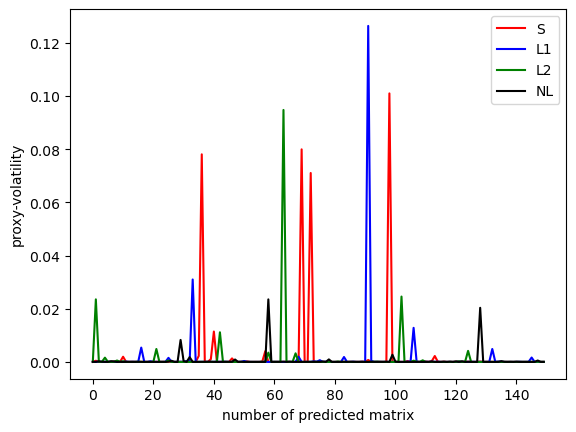

In [36]:
# You can choose different start and end params for more/less detailed picture
# Non-linear shrinkage has the least number of volatilities explosion
# So that way of matrix regularization shows its own power
start = 0
end = 150
plt.plot(volatility_results['S']['volatilities in-sample list'][start:end], color='red', label='S')
plt.plot(volatility_results['L1']['volatilities in-sample list'][start:end], color='blue', label='L1')
plt.plot(volatility_results['L2']['volatilities in-sample list'][start:end], color='green', label='L2')
plt.plot(volatility_results['NL']['volatilities in-sample list'][start:end], color='black', label='NL')
plt.xlabel('number of predicted matrix')
plt.ylabel('proxy-volatility')
plt.legend()
plt.show()

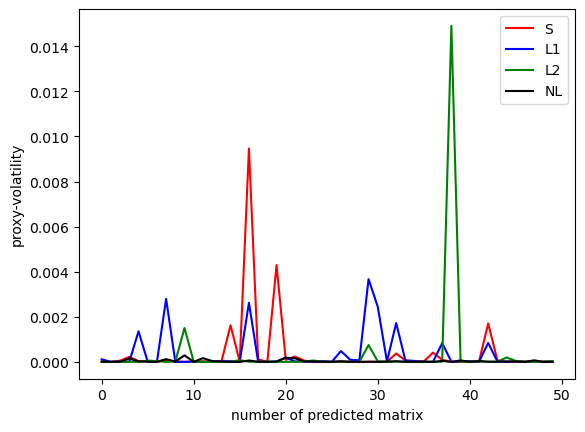

In [40]:
# Out-of-sample picture
start = 0
end = 50
plt.plot(volatility_results['S']['volatilities out-of-sample list'][start:end], color='red', label='S')
plt.plot(volatility_results['L1']['volatilities out-of-sample list'][start:end], color='blue', label='L1')
plt.plot(volatility_results['L2']['volatilities out-of-sample list'][start:end], color='green', label='L2')
plt.plot(volatility_results['NL']['volatilities out-of-sample list'][start:end], color='black', label='NL')
plt.xlabel('number of predicted matrix')
plt.ylabel('proxy-volatility')
plt.legend()
plt.show()